# **Data Cleaning and Data Preprocessing**

In [31]:
# Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import f1_score, roc_auc_score, classification_report, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


In [2]:
# Load dataset

DATA_PATH = "bank-full.csv"

df = pd.read_csv(DATA_PATH, sep=";") # This dataset is semicolon-separated


In [3]:
# Show first 5 columns

df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [4]:
# Show last 5 columns

df.tail()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,yes
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no
45210,37,entrepreneur,married,secondary,no,2971,no,no,cellular,17,nov,361,2,188,11,other,no


In [5]:
# Inspect dataset

print("Shape:", df.shape) # Check shape
print("Columns:", df.columns.tolist()) # Check column name
print("Basic Info", df.info()) # Check basic information
print("\nTarget distribution (counts):\n", df["y"].value_counts()) # Count the subscription outcomes 'yes' and 'no'
print("\nTarget distribution (rate):\n", df["y"].value_counts(normalize=True).round(4)) # Calculate the subscription outcomes in portion

Shape: (45211, 17)
Columns: ['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'y']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null 

In [6]:
# Check missing value

print("\nMissing values per column:\n", df.isna().sum().sort_values(ascending=False).head(10))


Missing values per column:
 age         0
day         0
poutcome    0
previous    0
pdays       0
campaign    0
duration    0
month       0
contact     0
job         0
dtype: int64


In [7]:
# Check duplicate value

print("\nThe number column of duplicated values:\n", df.duplicated().sum())


The number column of duplicated values:
 0


In [8]:
# Count 'unknown' categories

obj_cols = df.select_dtypes(include="object").columns
unknown_counts = {c: (df[c] == "unknown").sum() for c in obj_cols if c != "y"}
unknown_counts = pd.Series(unknown_counts).sort_values(ascending=False)
print("\nTop 'unknown' counts:\n", unknown_counts.head(10))



Top 'unknown' counts:
 poutcome     36959
contact      13020
education     1857
job            288
marital          0
default          0
housing          0
loan             0
month            0
dtype: int64


In [9]:
# Quick numeric sanity checks

num_cols = df.select_dtypes(include=[np.number]).columns
print("\nNumeric summary (selected):\n", df[num_cols].describe().T[["min", "50%", "max"]].head(10))


Numeric summary (selected):
              min    50%       max
age         18.0   39.0      95.0
balance  -8019.0  448.0  102127.0
day          1.0   16.0      31.0
duration     0.0  180.0    4918.0
campaign     1.0    2.0      63.0
pdays       -1.0   -1.0     871.0
previous     0.0    0.0     275.0


In [10]:
# Drop missing value

# df_clean = df.dropna()

# Because there is no na, so not neccessary to drop na.

In [11]:
# Make a copy

df_clean = df.copy()

In [12]:
# Drop leakage feature: pre-call

if "duration" in df_clean.columns:
    df_clean = df_clean.drop(columns=["duration"])

In [13]:
# Remove duplicate

before = df_clean.shape[0]
df_clean = df_clean.drop_duplicates()
after = df_clean.shape[0]
print(f"\nDuplicates removed: {before - after}")


Duplicates removed: 16


In [14]:
# Treat day as categorical

df_clean["day"] = df_clean["day"].astype("object")

In [15]:
# Define X and y

X = df_clean.drop(columns=["y"])
y = df_clean["y"].map({"no": 0, "yes": 1})

In [16]:
# Split (stratified): test 20% and train 80%

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train shape:", X_train.shape, " Test shape:", X_test.shape)
print("Train positive rate:", round(y_train.mean(), 3), " Test positive rate:", round(y_test.mean(), 3))

Train shape: (36156, 15)  Test shape: (9039, 15)
Train positive rate: 0.117  Test positive rate: 0.117


In [17]:
# Preprocessing pipeline

# Identify categorical and numerical columns after dropping duration

categorical_features = X.select_dtypes(include="object").columns.tolist()
numerical_features = X.select_dtypes(include=[np.number]).columns.tolist()

print("Categorical features:", categorical_features)
print("Numerical features:", numerical_features)

# Note on "unknown":
# For bank-full, treating "unknown" as its own category is usually reasonable.
# OneHotEncoder will handle it naturally.

preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_features),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_features),
    ],
    remainder="drop"
)

_ = preprocess.fit_transform(X_train)
print("Preprocess OK")

Categorical features: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'day', 'month', 'poutcome']
Numerical features: ['age', 'balance', 'campaign', 'pdays', 'previous']
Preprocess OK


In [18]:
#Recheck the "duration" to make sure that it is not included
print("duration in X?", "duration" in X.columns)  # should be False
print("Numerical features:", numerical_features)

duration in X? False
Numerical features: ['age', 'balance', 'campaign', 'pdays', 'previous']


# **Exploratory Data Analysis (EDA)**

In [20]:
# subscription rate table
def rate_table(df, col, top_n=10):
    tmp = (
        df.groupby(col)["y"]
          .apply(lambda s: (s == "yes").mean())
          .sort_values(ascending=False)
          .head(top_n)
    )
    return tmp

In [21]:
# Overall class balance

y_counts = df_clean["y"].value_counts()
y_rate = df_clean["y"].value_counts(normalize=True)

print("Overall target counts:\n", y_counts)
print("\nOverall target rate:\n", y_rate.round(4))

Overall target counts:
 y
no     39906
yes     5289
Name: count, dtype: int64

Overall target rate:
 y
no     0.883
yes    0.117
Name: proportion, dtype: float64


In [22]:
# Numeric distributions and outliers

num_cols = ["age", "balance", "campaign", "pdays", "previous"]
print("\nNumeric summary:\n", df_clean[num_cols].describe().T[["min","25%","50%","75%","max"]])


Numeric summary:
              min   25%    50%     75%       max
age         18.0  33.0   39.0    48.0      95.0
balance  -8019.0  72.0  449.0  1428.0  102127.0
campaign     1.0   1.0    2.0     3.0      63.0
pdays       -1.0  -1.0   -1.0    -1.0     871.0
previous     0.0   0.0    0.0     0.0     275.0


In [23]:
# check skew / extreme values quickly

for c in num_cols:
    q99 = df_clean[c].quantile(0.99)
    print(f"{c}: 99th percentile={q99}, max={df_clean[c].max()}")

age: 99th percentile=71.0, max=95
balance: 99th percentile=13166.259999999951, max=102127
campaign: 99th percentile=16.0, max=63
pdays: 99th percentile=370.0, max=871
previous: 99th percentile=9.0, max=275


In [24]:
# Subscription rate by key categorical variables

cat_cols = ["poutcome", "contact", "month", "job", "education", "marital", "housing", "loan", "default", "day"]

for c in ["poutcome", "contact", "month", "housing", "loan", "default"]:
    print(f"\nSubscription rate by {c}:\n", rate_table(df_clean, c, top_n=20).round(4))


Subscription rate by poutcome:
 poutcome
success    0.6473
other      0.1668
failure    0.1261
unknown    0.0917
Name: y, dtype: float64

Subscription rate by contact:
 contact
cellular     0.1493
telephone    0.1342
unknown      0.0407
Name: y, dtype: float64

Subscription rate by month:
 month
mar    0.5199
dec    0.4673
sep    0.4646
oct    0.4377
apr    0.1968
feb    0.1665
aug    0.1103
jun    0.1022
nov    0.1015
jan    0.1012
jul    0.0910
may    0.0672
Name: y, dtype: float64

Subscription rate by housing:
 housing
no     0.1671
yes    0.0770
Name: y, dtype: float64

Subscription rate by loan:
 loan
no     0.1266
yes    0.0668
Name: y, dtype: float64

Subscription rate by default:
 default
no     0.1180
yes    0.0638
Name: y, dtype: float64


In [25]:
# Compare numeric features by target (mean/median)

group_stats = df_clean.groupby("y")[num_cols].agg(["mean", "median"])
print("\nNumeric feature comparison by y:\n", group_stats)


Numeric feature comparison by y:
            age             balance         campaign             pdays         \
          mean median         mean median      mean median       mean median   
y                                                                              
no   40.840525   39.0  1304.237684  417.0  2.846539    2.0  36.436375   -1.0   
yes  41.670070   38.0  1804.267915  733.0  2.141047    2.0  68.702968   -1.0   

     previous         
         mean median  
y                     
no   0.502356    0.0  
yes  1.170354    0.0  


In [26]:
# Simple correlation among numeric variables (not with y because y is categorical)

corr = df_clean[num_cols].corr()
print("\nCorrelation among numeric features:\n", corr.round(3))


Correlation among numeric features:
             age  balance  campaign  pdays  previous
age       1.000    0.098     0.005 -0.024     0.001
balance   0.098    1.000    -0.015  0.003     0.017
campaign  0.005   -0.015     1.000 -0.089    -0.033
pdays    -0.024    0.003    -0.089  1.000     0.455
previous  0.001    0.017    -0.033  0.455     1.000


In [27]:
# which months have higher/lower subscription

month_rates = df_clean.groupby("month")["y"].apply(lambda s: (s=="yes").mean()).sort_values(ascending=False)
print("\nMonth subscription rates (all):\n", month_rates.round(4))


Month subscription rates (all):
 month
mar    0.5199
dec    0.4673
sep    0.4646
oct    0.4377
apr    0.1968
feb    0.1665
aug    0.1103
jun    0.1022
nov    0.1015
jan    0.1012
jul    0.0910
may    0.0672
Name: y, dtype: float64


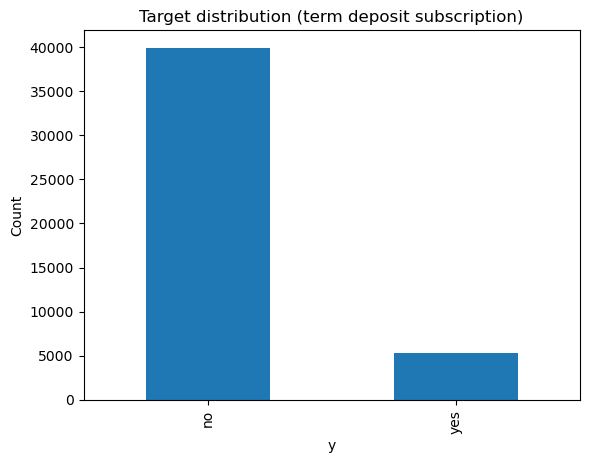

In [28]:
# Target distribution

df_clean["y"].value_counts().plot(kind="bar")
plt.xlabel("y")
plt.ylabel("Count")
plt.title("Target distribution (term deposit subscription)")
plt.show()

In [29]:
# subscription rate bar chart

def plot_rate(col, top_n=None):
    rates = df_clean.groupby(col)["y"].apply(lambda s: (s=="yes").mean())
    if top_n:
        # for high-cardinality cols, show top_n by frequency
        top = df_clean[col].value_counts().head(top_n).index
        rates = rates.loc[top]
    rates.sort_values(ascending=False).plot(kind="bar")
    plt.ylabel("Subscription rate (P(y=yes))")
    plt.title(f"Subscription rate by {col}")
    plt.show()

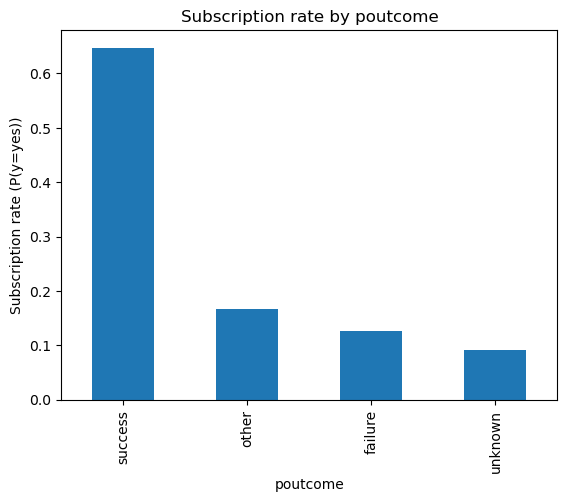

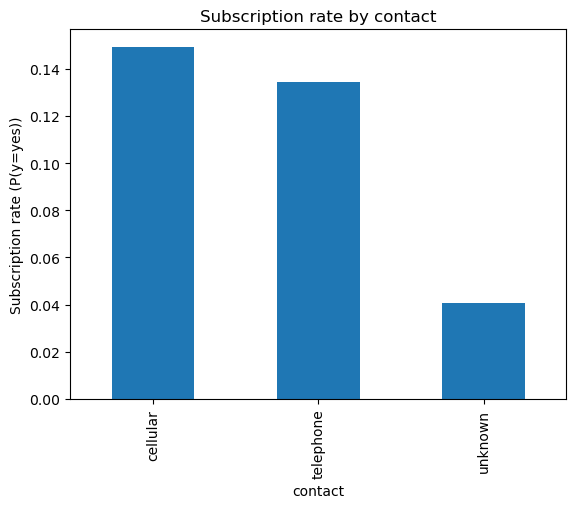

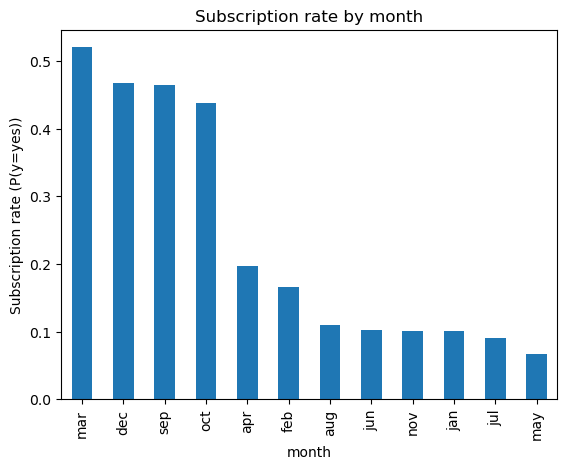

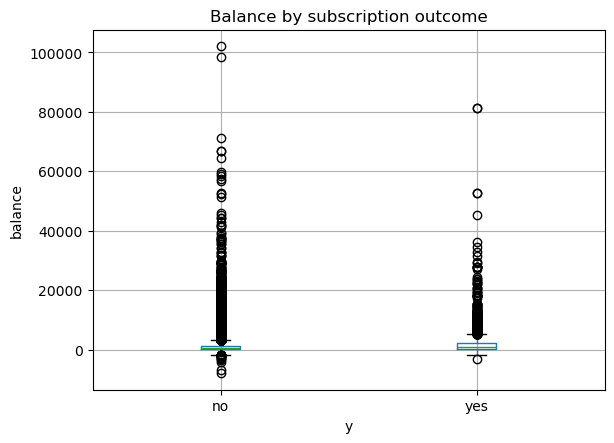

In [30]:
# poutcome
plot_rate("poutcome")

# contact or month
plot_rate("contact")
plot_rate("month")  # choose one if you want fewer figures

# balance boxplot by y
df_clean.boxplot(column="balance", by="y")
plt.title("Balance by subscription outcome")
plt.suptitle("")
plt.xlabel("y")
plt.ylabel("balance")
plt.show()

# **Modelling approach**

This section compares three classification models for the pre-call term-deposit prediction task:
  - Loistic Regression
  - Random Forest
  - XGBoost

In [32]:
# -----------------------------
# 1. Define models
# -----------------------------

log_reg = LogisticRegression(
    max_iter=2000,
    class_weight="balanced",
    random_state=42
)

rf = RandomForestClassifier(
    n_estimators=400,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1,
    class_weight="balanced_subsample"
)

# scale_pos_weight ≈ neg/pos (from your dataset: no=0.883, yes=0.117)
scale_pos_weight = 0.883 / 0.117

xgb = XGBClassifier(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1,
    eval_metric="logloss",
    tree_method="hist",
    scale_pos_weight=scale_pos_weight
)

models = {
    "Logistic Regression": log_reg,
    "Random Forest": rf,
    "XGBoost": xgb
}

# -----------------------------
# 2. Cross-validation on training set
# -----------------------------

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = {"f1": "f1", "roc_auc": "roc_auc"}

cv_rows = []
pipes = {}

for name, model in models.items():
    pipe = Pipeline(steps=[
        ("preprocess", preprocess),
        ("model", model)
    ])
    pipes[name] = pipe

    scores = cross_validate(
        pipe,
        X_train, y_train,
        cv=cv,
        scoring=scoring,
        return_train_score=False
    )

    cv_rows.append({
        "Model": name,
        "CV F1 (mean)": scores["test_f1"].mean(),
        "CV F1 (std)": scores["test_f1"].std(),
        "CV ROC-AUC (mean)": scores["test_roc_auc"].mean(),
        "CV ROC-AUC (std)": scores["test_roc_auc"].std(),
    })

cv_results = pd.DataFrame(cv_rows).sort_values("CV F1 (mean)", ascending=False)
print("\nCross-validation results (train set):")
print(cv_results.round(4))

# -----------------------------
# 3. Fit on full training set and evaluate on test set
# -----------------------------

test_rows = []
fitted = {}

for name, pipe in pipes.items():
    pipe.fit(X_train, y_train)
    fitted[name] = pipe

    y_pred = pipe.predict(X_test)

    # ROC-AUC needs probabilities
    y_proba = pipe.predict_proba(X_test)[:, 1]
    test_rows.append({
        "Model": name,
        "Test F1": f1_score(y_test, y_pred),
        "Test ROC-AUC": roc_auc_score(y_test, y_proba),
    })

test_results = pd.DataFrame(test_rows).sort_values("Test F1", ascending=False)
print("\nTest set results:")
print(test_results.round(4))

# -----------------------------
# 4. Detailed diagnostics for the best model (by Test F1)
# -----------------------------

best_name = test_results.iloc[0]["Model"]
best_pipe = fitted[best_name]

print(f"\nBest model by Test F1: {best_name}")

best_pred = best_pipe.predict(X_test)
print("\nConfusion matrix:")
print(confusion_matrix(y_test, best_pred))

print("\nClassification report:")
print(classification_report(y_test, best_pred, digits=4))


Cross-validation results (train set):
                 Model  CV F1 (mean)  CV F1 (std)  CV ROC-AUC (mean)  \
1        Random Forest        0.4487       0.0135             0.7907   
2              XGBoost        0.4363       0.0102             0.7961   
0  Logistic Regression        0.3854       0.0052             0.7697   

   CV ROC-AUC (std)  
1            0.0091  
2            0.0106  
0            0.0083  

Test set results:
                 Model  Test F1  Test ROC-AUC
1        Random Forest   0.4447        0.7993
2              XGBoost   0.4388        0.7986
0  Logistic Regression   0.3814        0.7755

Best model by Test F1: Random Forest

Confusion matrix:
[[7507  474]
 [ 620  438]]

Classification report:
              precision    recall  f1-score   support

           0     0.9237    0.9406    0.9321      7981
           1     0.4803    0.4140    0.4447      1058

    accuracy                         0.8790      9039
   macro avg     0.7020    0.6773    0.6884      9039
w

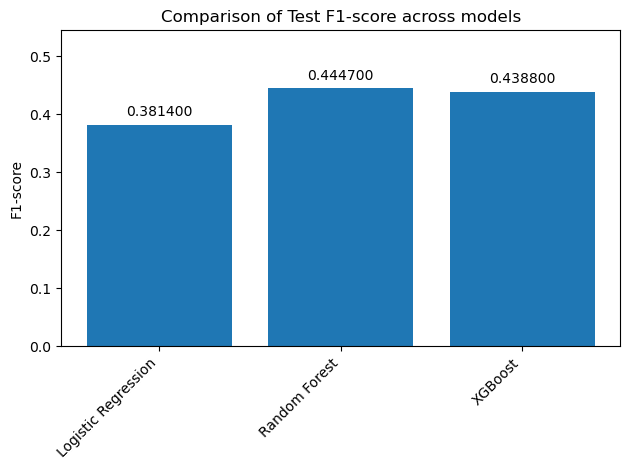

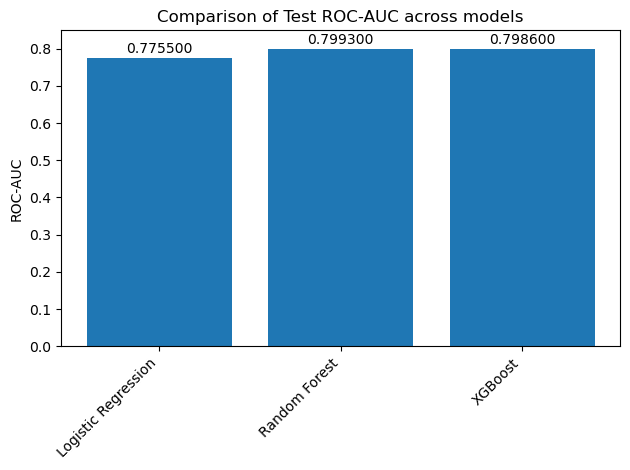

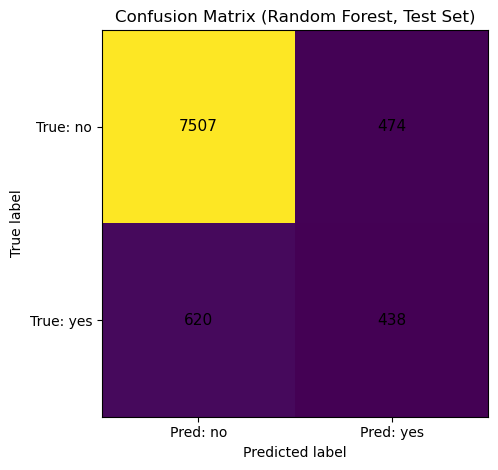

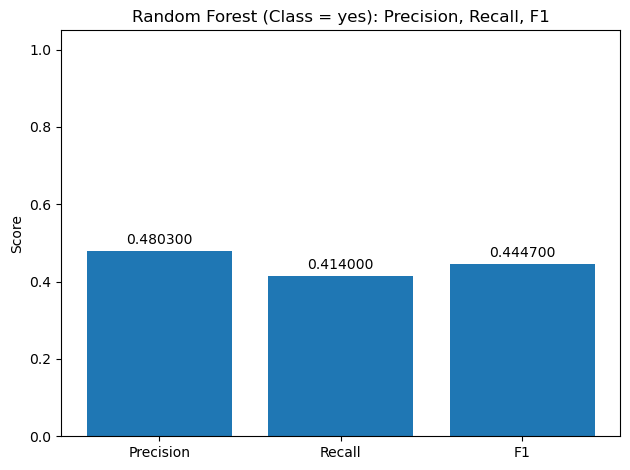

In [34]:
# -------------------------
# 0) add labels on top of bars
# -------------------------
def add_bar_labels(bars, fmt="{:.6f}", y_pad=0.01):
    for b in bars:
        h = b.get_height()
        plt.text(
            b.get_x() + b.get_width() / 2,
            h + y_pad,
            fmt.format(h),
            ha="center",
            va="bottom",
            fontsize=10
        )

# -------------------------
# 1) Your results
# -------------------------
results = pd.DataFrame({
    "Model": ["Logistic Regression", "Random Forest", "XGBoost"],
    "CV F1 (mean)": [0.3854, 0.4487, 0.4363],
    "CV ROC-AUC (mean)": [0.7697, 0.7907, 0.7961],
    "Test F1": [0.3814, 0.4447, 0.4388],
    "Test ROC-AUC": [0.7755, 0.7993, 0.7986],
})

# Confusion matrix (Random Forest, test set)
cm = np.array([[7507, 474],
               [ 620, 438]])

# Positive-class metrics (Random Forest, class "yes" = 1)
metrics_pos = pd.Series({
    "Precision": 0.4803,
    "Recall": 0.4140,
    "F1": 0.4447
})

# Save figures
SAVE = True
OUT_DIR = "figures"
if SAVE:
    os.makedirs(OUT_DIR, exist_ok=True)


# -------------------------
# 2) Plot A: Test F1
# -------------------------
plt.figure()
bars = plt.bar(results["Model"], results["Test F1"])
add_bar_labels(bars, fmt="{:.6f}", y_pad=0.01)
plt.ylabel("F1-score")
plt.title("Comparison of Test F1-score across models")
plt.xticks(rotation=45, ha="right")
plt.ylim(0, min(1.0, results["Test F1"].max() + 0.10))
plt.tight_layout()
if SAVE:
    plt.savefig(os.path.join(OUT_DIR, "test_f1_comparison.png"), dpi=300)
plt.show()


# -------------------------
# 3) Plot B: Test ROC-AUC
# -------------------------
plt.figure()
bars = plt.bar(results["Model"], results["Test ROC-AUC"])
add_bar_labels(bars, fmt="{:.6f}", y_pad=0.005)
plt.ylabel("ROC-AUC")
plt.title("Comparison of Test ROC-AUC across models")
plt.xticks(rotation=45, ha="right")
plt.ylim(0, min(1.0, results["Test ROC-AUC"].max() + 0.05))
plt.tight_layout()
if SAVE:
    plt.savefig(os.path.join(OUT_DIR, "test_rocauc_comparison.png"), dpi=300)
plt.show()


# -------------------------
# 4) Plot C: Confusion Matrix (Random Forest)
# -------------------------
plt.figure()
plt.imshow(cm)
plt.title("Confusion Matrix (Random Forest, Test Set)")
plt.xticks([0, 1], ["Pred: no", "Pred: yes"])
plt.yticks([0, 1], ["True: no", "True: yes"])
plt.xlabel("Predicted label")
plt.ylabel("True label")

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i, j]), ha="center", va="center", fontsize=11)

plt.tight_layout()
if SAVE:
    plt.savefig(os.path.join(OUT_DIR, "confusion_matrix_random_forest.png"), dpi=300)
plt.show()


# -------------------------
# 5) Plot D: Positive-class metrics (Random Forest)
# -------------------------
plt.figure()
bars = plt.bar(metrics_pos.index, metrics_pos.values)
add_bar_labels(bars, fmt="{:.6f}", y_pad=0.01)
plt.ylim(0, 1.05)
plt.ylabel("Score")
plt.title("Random Forest (Class = yes): Precision, Recall, F1")
plt.tight_layout()
if SAVE:
    plt.savefig(os.path.join(OUT_DIR, "rf_positive_class_metrics.png"), dpi=300)
plt.show()